In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/jj.csv")

In [ ]:
len(df)

84

In [ ]:
df.head()

date  data
0  1960-01-01  0.71
1  1960-04-01  0.63
2  1960-07-02  0.85
3  1960-10-01  0.44
4  1961-01-01  0.61

In [ ]:
df['date']=pd.to_datetime(df.date)

In [ ]:
df.set_index('date',inplace=True)

In [ ]:
df.head()

data
date            
1960-01-01  0.71
1960-04-01  0.63
1960-07-02  0.85
1960-10-01  0.44
1961-01-01  0.61

In [ ]:
df.plot()

<Axes: xlabel='date'>

In [ ]:
import statsmodels.api as sm

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df,model='additive')
fig=decomposition.plot()
plt.show()

ValueError: ignored

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller_test= adfuller(df)
print("pvalue of adfuller test is ",adfuller_test[1])
#if the pvalue is greater than 0.05 the series is not stationary

pvalue of adfuller test is  0.00041497314044406584


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

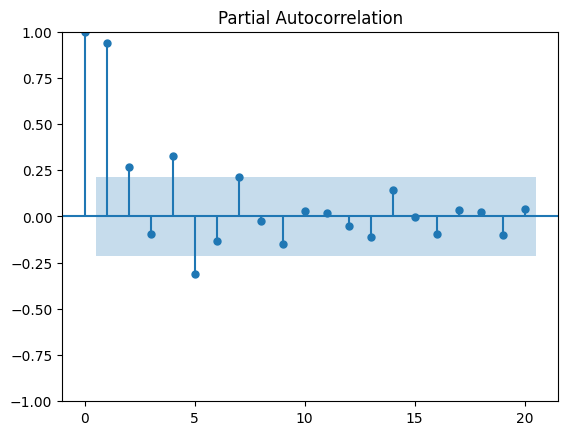

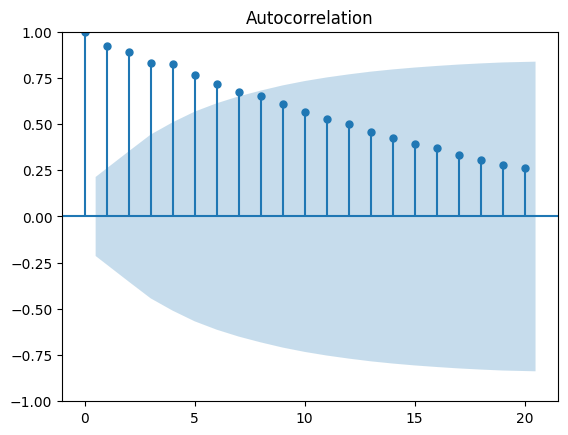

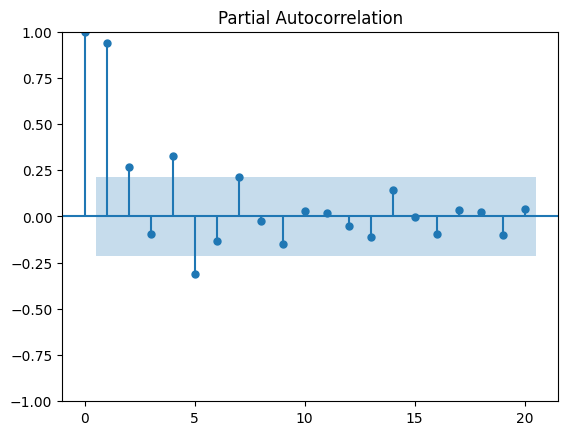

In [ ]:
plot_acf(df.data)
plot_pacf(df.data)

In [ ]:
df['data'] = np.log(df['data'])
df['data'] = df['data'].diff()
df = df.drop(df.index[0])
df.head()

data
date                
1960-04-01 -0.119545
1960-07-02  0.299517
1960-10-01 -0.658462
1961-01-01  0.326684
1961-04-02  0.123233

In [ ]:
df.to_csv("new_csv.csv")

In [ ]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(df['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

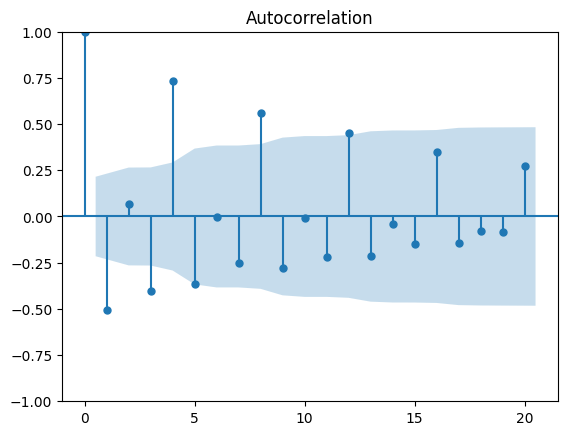

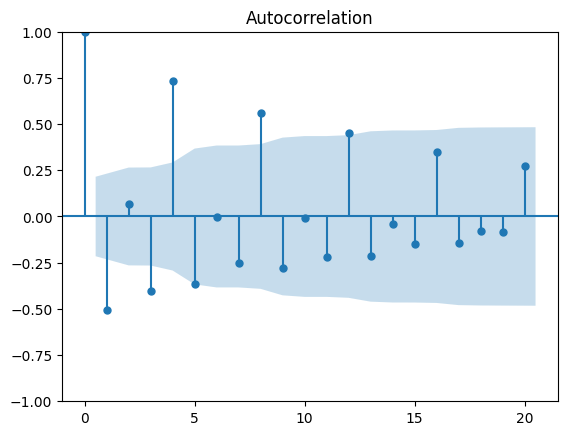

In [ ]:
plot_acf(df.data)

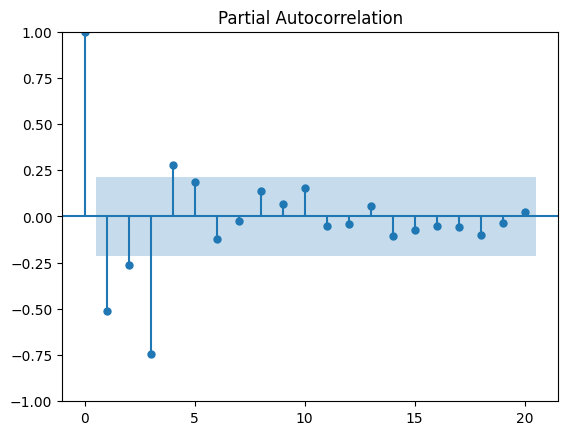

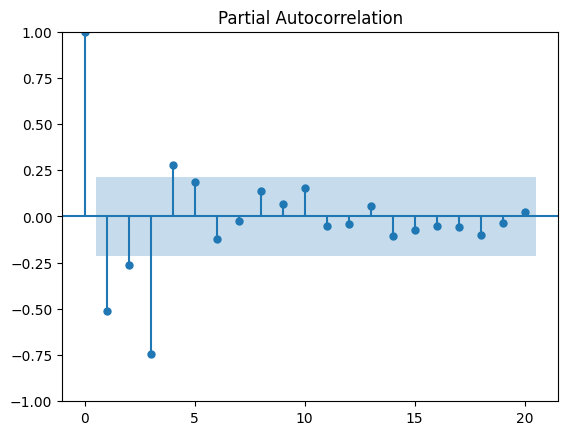

In [ ]:
plot_pacf(df.data)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
import itertools
from itertools import product

In [ ]:
train=df[:60]
test=df[60:]

In [ ]:
train.plot()

<Axes: xlabel='date'>

<Axes: xlabel='date'>

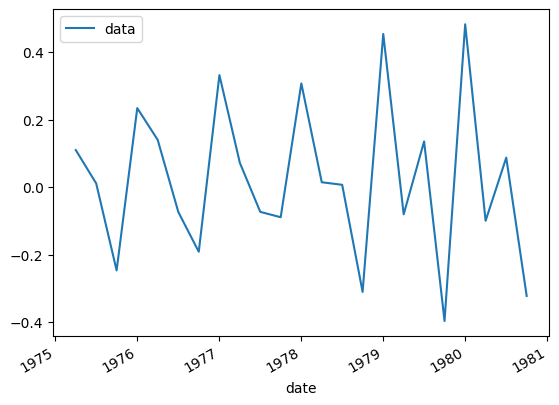

In [ ]:
test.plot()

In [ ]:
p=range(0,8)
q=range(0,8)
d=range(0,2)

In [ ]:
pdq_comb = list(itertools.product(p,d,q))

In [ ]:
len(pdq_comb)

128

In [ ]:
rmse=[]
order1=[]

In [ ]:
for pdq in pdq_comb:
    model=ARIMA(train,order=pdq).fit()
    pred= model.predict(start=len(train),end=(len(df)-1))
    error=np.sqrt(mean_squared_error(test,pred))
    order1.append(pdq)
    rmse.append(error)

In [ ]:
results=pd.DataFrame(index=order1,data=rmse,columns=["RMSE"])

In [ ]:
results.to_csv("Arima_results_new.csv")

In [ ]:
#creating model with new hyperparameters from itertions
#p=7 d=1 q=6
model1= ARIMA(train,order=(7,1,6)).fit()

In [ ]:
pred1= model1.predict(start=len(train),end=(len(df)-1))

In [ ]:
error= np.sqrt(mean_squared_error(test,pred1))
error

0.14878369222520296

In [ ]:
(test.mean(),np.sqrt(test.var()))

(data    0.022435
 dtype: float64,
 data    0.23767
 dtype: float64)

<Axes: xlabel='date'>

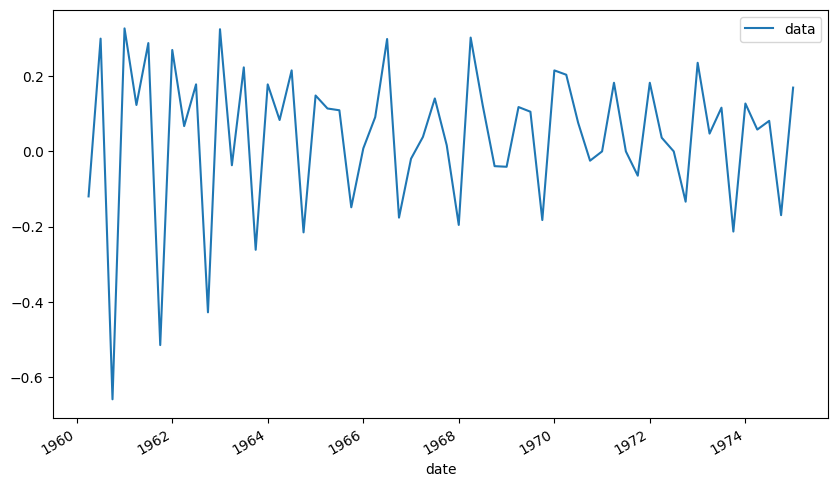

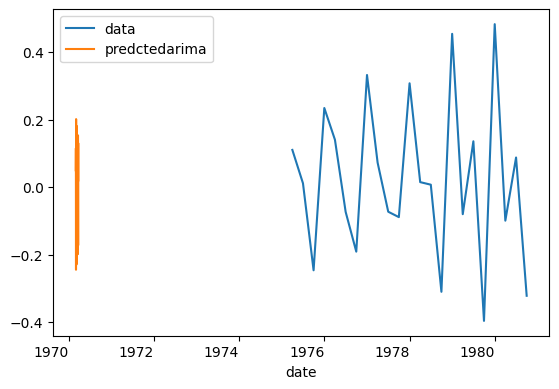

In [ ]:
train.plot(legend=True,label='Train',figsize=(10,6))
test.plot(legend=True,label='test')
pred1.plot(legend=True,label='predctedarima')

In [ ]:
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   60
Model:                 ARIMA(7, 1, 6)   Log Likelihood                  55.347
Date:                Tue, 25 Apr 2023   AIC                            -82.695
Time:                        07:43:50   BIC                            -53.609
Sample:                             0   HQIC                           -71.341
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5884      0.279     -5.687      0.000      -2.136      -1.041
ar.L2         -1.3268      0.479     -2.771      0.006      -2.265      -0.388
ar.L3         -1.6029      0.606     -2.644      0.0

In [ ]:
#alternative method

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook


def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=df['data'])

result_df

  0%|          | 0/64 [00:00<?, ?it/s]

(p, d, q)         AIC
0   (3, 1, 3) -142.041665
1   (7, 1, 1) -141.634191
2   (7, 1, 5) -141.451368
3   (3, 1, 1) -140.470572
4   (3, 1, 4) -140.453181
..        ...         ...
59  (1, 1, 1)  -37.106446
60  (0, 1, 1)  -14.645882
61  (2, 1, 0)   14.952068
62  (1, 1, 0)   17.545808
63  (0, 1, 0)   68.249842

[64 rows x 2 columns]

In [ ]:
model2=ARIMA(train,order=(3,1,3)).fit()

In [ ]:
pred2= model2.predict(start=len(train),end=(len(df)-1))
pred2.head()

60    0.057574
61    0.096239
62   -0.152520
63    0.154514
64    0.055989
Name: predicted_mean, dtype: float64

In [ ]:
daprint(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   60
Model:                 ARIMA(3, 1, 3)   Log Likelihood                  50.705
Date:                Mon, 24 Apr 2023   AIC                            -87.410
Time:                        13:26:47   BIC                            -72.867
Sample:                             0   HQIC                           -81.733
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9672      0.068    -14.187      0.000      -1.101      -0.834
ar.L2         -0.9405      0.071    -13.281      0.000      -1.079      -0.802
ar.L3         -0.9192      0.041    -22.683      0.0